In [84]:
import json
import math
import copy
import sys
import warnings
from os import sep
import os.path as op
import numpy as np
import time
from fooof import FOOOF
from extra.tools import many_is_in
from mne import read_epochs
from utilities import files
import matplotlib.pylab as plt


from mne.filter import filter_data
from scipy.signal import argrelextrema, hilbert
from scipy.stats import linregress

In [5]:
superlet_folder = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo"
epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo.fif"

In [30]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def overlap(a,b):
    return a[0] <= b[0] <= a[1] or b[0] <= a[0] <= b[1]


def fwhm_burst_norm(TF, peak):
    right_loc = np.nan
    cand=np.where(TF[peak[0],peak[1]:]<=TF[peak]/2)[0]
    if len(cand):
        right_loc=cand[0]

    up_loc = np.nan
    cand=np.where(TF[peak[0]:, peak[1]] <= TF[peak] / 2)[0]
    if len(cand):
        up_loc=cand[0]

    left_loc = np.nan
    cand=np.where(TF[peak[0],:peak[1]]<=TF[peak]/2)[0]
    if len(cand):
        left_loc = peak[1]-cand[-1]

    down_loc = np.nan
    cand=np.where(TF[:peak[0],peak[1]]<=TF[peak]/2)[0]
    if len(cand):
        down_loc = peak[0]-cand[-1]

    if down_loc is np.nan:
        down_loc = up_loc
    if up_loc is np.nan:
        up_loc = down_loc
    if left_loc is np.nan:
        left_loc = right_loc
    if right_loc is np.nan:
        right_loc = left_loc

    
    horiz = np.nanmin([left_loc, right_loc])
    vert = np.nanmin([up_loc, down_loc])
    right_loc = horiz
    left_loc = horiz
    up_loc = vert
    down_loc = vert
    return right_loc, left_loc, up_loc, down_loc



def extract_bursts(raw_trials, TF, times, search_freqs, band_lims, fooof_thresh, sfreq, w_size=.2):
    bursts = {
        'trial': [],
        'waveform': [],
        'peak_freq': [],
        'peak_amp_iter': [],
        'peak_amp_base': [],
        'peak_time': [],
        'peak_adjustment': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'polarity': [],
    }

    # Compute ERF
    erf=np.mean(raw_trials, axis=0)

    # Grid for computing 2D Gaussians
    x_idx, y_idx = np.meshgrid(range(len(times)), range(len(search_freqs)))

    # Window size in points
    wlen = int(w_size * sfreq)
    half_wlen = int(wlen * .5)

    # Iterate through trials
    for t_idx, tr in enumerate(TF):

        # Subtract 1/f threshold
        trial_TF = tr - fooof_thresh
        trial_TF[trial_TF < 0] = 0

        # skip the thing if: see the 
        if (trial_TF == 0).all():
            print("All values equal 0 after Fooof subtraction in Trial {} ".format(t_idx))
            continue
        
        # TF for iterating
        trial_TF_iter = copy.copy(trial_TF)

        # Regress out ERF
        slope, intercept, r, p, se = linregress(erf, raw_trials[t_idx, :])
        raw_trials[t_idx, :] = raw_trials[t_idx, :] - (intercept + slope * erf)

        while True:
            # Compute noise floor
            thresh = 2 * np.std(trial_TF_iter)

            # Find peak
            [peak_freq_idx, peak_time_idx] = np.unravel_index(np.argmax(trial_TF_iter), trial_TF.shape)
            peak_freq = search_freqs[peak_freq_idx]
            peak_amp_iter = trial_TF_iter[peak_freq_idx, peak_time_idx]
            peak_amp_base = trial_TF[peak_freq_idx, peak_time_idx]
            if peak_amp_iter < thresh:
                break

            # Fit 2D Gaussian and subtract from TF
            right_loc, left_loc, up_loc, down_loc = fwhm_burst_norm(trial_TF_iter, (peak_freq_idx, peak_time_idx))

            # REMOVE DEGENERATE GAUSSIAN
            vert_isnan = any(np.isnan([up_loc, down_loc]))
            horiz_isnan = any(np.isnan([right_loc, left_loc]))
            if vert_isnan:
                v_sh = int((search_freqs.shape[0] - peak_freq_idx) / 2)
                if v_sh <= 0:
                    v_sh = 1
                up_loc = v_sh
                down_loc = v_sh

            elif horiz_isnan:
                h_sh = int((times.shape[0] - peak_time_idx) / 2)
                if h_sh <= 0:
                    h_sh = 1
                right_loc = h_sh
                left_loc = h_sh

            hv_isnan = any([vert_isnan, horiz_isnan])

            fwhm_f_idx = up_loc + down_loc
            fwhm_f = (search_freqs[1] - search_freqs[0]) * fwhm_f_idx
            fwhm_t_idx = left_loc + right_loc
            fwhm_t = (times[1] - times[0]) * fwhm_t_idx
            sigma_t = (fwhm_t_idx) / 2.355
            sigma_f = (fwhm_f_idx) / 2.355
            z = peak_amp_iter * gaus2d(x_idx, y_idx, mx=peak_time_idx, my=peak_freq_idx, sx=sigma_t, sy=sigma_f)
            new_trial_TF_iter = trial_TF_iter - z

            if all([peak_freq >= band_lims[0], peak_freq <= band_lims[1], not hv_isnan]):
                # Extract raw burst signal
                dur = [
                    np.max([0, peak_time_idx - left_loc]),
                    np.min([raw_trials.shape[1], peak_time_idx + right_loc])
                ]
                raw_signal = raw_trials[t_idx, dur[0]:dur[1]].reshape(1, -1)

                # Bandpass filter
                freq_range = [
                    np.max([0, peak_freq_idx - down_loc]),
                    np.min([len(search_freqs) - 1, peak_freq_idx + up_loc])
                ]
                filtered = filter_data(raw_signal, sfreq, search_freqs[freq_range[0]], search_freqs[freq_range[1]],
                                       verbose=False)

                # Hilbert transform
                analytic_signal = hilbert(filtered)
                # Get phase
                instantaneous_phase = np.unwrap(np.angle(analytic_signal)) % math.pi

                # Find phase local minima (near 0)
                zero_phase_pts = argrelextrema(instantaneous_phase.T, np.less)[0]
                # Find local phase minima with negative deflection closest to TF peak
                # If no minimum is found, the error is caught and no burst is added
                try:
                    closest_pt = zero_phase_pts[np.argmin(np.abs((dur[1] - dur[0]) * .5 - zero_phase_pts))]
                    new_peak_time_idx = dur[0] + closest_pt
                    adjustment = (new_peak_time_idx - peak_time_idx) * 1 / sfreq
                except:
                    adjustment = 1
                # Keep if adjustment less than 30ms
                if np.abs(adjustment) < .03:

                    # If burst won't be cutoff
                    if new_peak_time_idx >= half_wlen and new_peak_time_idx + half_wlen <= raw_trials.shape[1]:
                        peak_time = times[new_peak_time_idx]

                        overlapped = False
                        t_bursts = np.where(bursts['trial'] == t_idx)[0]
                        # Check for overlap
                        for b_idx in t_bursts:
                            o_t = bursts['peak_time'][b_idx]
                            o_fwhm_t = bursts['fwhm_time'][b_idx]
                            if overlap([peak_time - .5 * fwhm_t, peak_time + .5 * fwhm_t],
                                       [o_t - .5 * o_fwhm_t, o_t + .5 * o_fwhm_t]):
                                overlapped = True
                                break

                        if not overlapped:
                            # Get burst
                            burst = raw_trials[t_idx, new_peak_time_idx - half_wlen:new_peak_time_idx + half_wlen]
                            ## Remove DC offset
                            burst = burst - np.mean(burst)
                            burst_times = times[new_peak_time_idx - half_wlen:new_peak_time_idx + half_wlen] - times[
                                new_peak_time_idx]

                            # Flip if positive deflection
                            peak_dists = np.abs(argrelextrema(filtered.T, np.greater)[0] - closest_pt)
                            trough_dists = np.abs(argrelextrema(filtered.T, np.less)[0] - closest_pt)

                            polarity = 0
                            if len(trough_dists) == 0 or (
                                    len(peak_dists) > 0 and np.min(peak_dists) < np.min(trough_dists)):
                                burst *= -1.0
                                polarity = 1
                            
                            bursts['trial'].append(int(t_idx))
                            bursts['waveform'].append(burst)
                            bursts['peak_freq'].append(peak_freq)
                            bursts['peak_amp_iter'].append(peak_amp_iter)
                            bursts['peak_amp_base'].append(peak_amp_base)
                            bursts['peak_time'].append(peak_time)
                            bursts['peak_adjustment'].append(adjustment)
                            bursts['fwhm_freq'].append(fwhm_f)
                            bursts['fwhm_time'].append(fwhm_t)
                            bursts['polarity'].append(polarity)

            trial_TF_iter = new_trial_TF_iter

    bursts['trial'] = np.array(bursts['trial'])
    bursts['waveform'] = np.array(bursts['waveform'])
    bursts['waveform_times'] = burst_times
    bursts['peak_freq'] = np.array(bursts['peak_freq'])
    bursts['peak_amp_iter'] = np.array(bursts['peak_amp_iter'])
    bursts['peak_amp_base'] = np.array(bursts['peak_amp_base'])
    bursts['peak_time'] = np.array(bursts['peak_time'])
    bursts['peak_adjustment'] = np.array(bursts['peak_adjustment'])
    bursts['fwhm_freq'] = np.array(bursts['fwhm_freq'])
    bursts['fwhm_time'] = np.array(bursts['fwhm_time'])
    bursts['polarity'] = np.array(bursts['polarity'])

    return bursts

In [238]:
def extract_bursts_edge(raw_trials, TF, times, search_freqs, band_lims, fooof_thresh, sfreq, w_size=.2):
    bursts = {
        'trial': [],
        'waveform': [],
        'peak_freq': [],
        'peak_amp_iter': [],
        'peak_amp_base': [],
        'peak_time': [],
        'peak_adjustment': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'polarity': [],
        'burst_cut_off': []
    }

    # Compute ERF
    erf=np.mean(raw_trials, axis=0)

    # Grid for computing 2D Gaussians
    x_idx, y_idx = np.meshgrid(range(len(times)), range(len(search_freqs)))

    # Window size in points
    wlen = int(w_size * sfreq)
    half_wlen = int(wlen * .5)

    # Iterate through trials
    for t_idx, tr in enumerate(TF):

        # Subtract 1/f threshold
        trial_TF = tr - fooof_thresh
        trial_TF[trial_TF < 0] = 0

        # skip the thing if: see the 
        if (trial_TF == 0).all():
            print("All values equal 0 after Fooof subtraction in Trial {} ".format(t_idx))
            continue
        
        # TF for iterating
        trial_TF_iter = copy.copy(trial_TF)

        # Regress out ERF
        slope, intercept, r, p, se = linregress(erf, raw_trials[t_idx, :])
        raw_trials[t_idx, :] = raw_trials[t_idx, :] - (intercept + slope * erf)

        while True:
            # Compute noise floor
            thresh = 2 * np.std(trial_TF_iter)

            # Find peak
            [peak_freq_idx, peak_time_idx] = np.unravel_index(np.argmax(trial_TF_iter), trial_TF.shape)
            peak_freq = search_freqs[peak_freq_idx]
            peak_amp_iter = trial_TF_iter[peak_freq_idx, peak_time_idx]
            peak_amp_base = trial_TF[peak_freq_idx, peak_time_idx]
            if peak_amp_iter < thresh:
                break

            # Fit 2D Gaussian and subtract from TF
            right_loc, left_loc, up_loc, down_loc = fwhm_burst_norm(trial_TF_iter, (peak_freq_idx, peak_time_idx))

            # REMOVE DEGENERATE GAUSSIAN
            vert_isnan = any(np.isnan([up_loc, down_loc]))
            horiz_isnan = any(np.isnan([right_loc, left_loc]))
            if vert_isnan:
                v_sh = int((search_freqs.shape[0] - peak_freq_idx) / 2)
                if v_sh <= 0:
                    v_sh = 1
                up_loc = v_sh
                down_loc = v_sh

            elif horiz_isnan:
                h_sh = int((times.shape[0] - peak_time_idx) / 2)
                if h_sh <= 0:
                    h_sh = 1
                right_loc = h_sh
                left_loc = h_sh

            hv_isnan = any([vert_isnan, horiz_isnan])

            fwhm_f_idx = up_loc + down_loc
            fwhm_f = (search_freqs[1] - search_freqs[0]) * fwhm_f_idx
            fwhm_t_idx = left_loc + right_loc
            fwhm_t = (times[1] - times[0]) * fwhm_t_idx
            sigma_t = (fwhm_t_idx) / 2.355
            sigma_f = (fwhm_f_idx) / 2.355
            z = peak_amp_iter * gaus2d(x_idx, y_idx, mx=peak_time_idx, my=peak_freq_idx, sx=sigma_t, sy=sigma_f)
            new_trial_TF_iter = trial_TF_iter - z
            
            # setup for intercepting bad edge TF peaks
            dodgy_peak_time = times[peak_time_idx]
            buffer = 0.125
            on_the_edge = any([dodgy_peak_time <= times[0] + buffer, dodgy_peak_time >= times[-1] - buffer])
            
            if all([peak_freq >= band_lims[0], peak_freq <= band_lims[1], not hv_isnan]):
                # Extract raw burst signal
                dur = [
                    np.max([0, peak_time_idx - left_loc]),
                    np.min([raw_trials.shape[1], peak_time_idx + right_loc])
                ]
                raw_signal = raw_trials[t_idx, dur[0]:dur[1]].reshape(1, -1)

                # Bandpass filter
                freq_range = [
                    np.max([0, peak_freq_idx - down_loc]),
                    np.min([len(search_freqs) - 1, peak_freq_idx + up_loc])
                ]
                filtered = filter_data(raw_signal, sfreq, search_freqs[freq_range[0]], search_freqs[freq_range[1]],
                                       verbose=False)

                # Hilbert transform
                analytic_signal = hilbert(filtered)
                # Get phase
                instantaneous_phase = np.unwrap(np.angle(analytic_signal)) % math.pi

                # Find phase local minima (near 0)
                zero_phase_pts = argrelextrema(instantaneous_phase.T, np.less)[0]
                # Find local phase minima with negative deflection closest to TF peak
                # If no minimum is found, the error is caught and no burst is added
                try:
                    closest_pt = zero_phase_pts[np.argmin(np.abs((dur[1] - dur[0]) * .5 - zero_phase_pts))]
                    new_peak_time_idx = dur[0] + closest_pt
                    adjustment = (new_peak_time_idx - peak_time_idx) * 1 / sfreq
                except:
                    adjustment = 1
                # Keep if adjustment less than 30ms
                if np.abs(adjustment) < .03:

                    # If burst won't be cutoff
                    if new_peak_time_idx >= half_wlen and new_peak_time_idx + half_wlen <= raw_trials.shape[1]:
                        peak_time = times[new_peak_time_idx]

                        overlapped = False
                        t_bursts = np.where(bursts['trial'] == t_idx)[0]
                        # Check for overlap
                        for b_idx in t_bursts:
                            o_t = bursts['peak_time'][b_idx]
                            o_fwhm_t = bursts['fwhm_time'][b_idx]
                            if overlap([peak_time - .5 * fwhm_t, peak_time + .5 * fwhm_t],
                                       [o_t - .5 * o_fwhm_t, o_t + .5 * o_fwhm_t]):
                                overlapped = True

                        if not overlapped:
                            # Get burst
                            burst = raw_trials[t_idx, new_peak_time_idx - half_wlen:new_peak_time_idx + half_wlen]
                            ## Remove DC offset
                            burst = burst - np.mean(burst)
                            burst_times = times[new_peak_time_idx - half_wlen:new_peak_time_idx + half_wlen] - times[
                                new_peak_time_idx]

                            # Flip if positive deflection
                            peak_dists = np.abs(argrelextrema(filtered.T, np.greater)[0] - closest_pt)
                            trough_dists = np.abs(argrelextrema(filtered.T, np.less)[0] - closest_pt)

                            polarity = 0
                            if len(trough_dists) == 0 or (
                                    len(peak_dists) > 0 and np.min(peak_dists) < np.min(trough_dists)):
                                burst *= -1.0
                                polarity = 1
                            
                            bursts['trial'].append(int(t_idx))
                            bursts['waveform'].append(burst)
                            bursts['peak_freq'].append(peak_freq)
                            bursts['peak_amp_iter'].append(peak_amp_iter)
                            bursts['peak_amp_base'].append(peak_amp_base)
                            bursts['peak_time'].append(peak_time)
                            bursts['peak_adjustment'].append(adjustment)
                            bursts['fwhm_freq'].append(fwhm_f)
                            bursts['fwhm_time'].append(fwhm_t)
                            bursts['polarity'].append(polarity)
                            bursts['burst_cut_off'].append(False)
            
            elif on_the_edge:
                bursts['trial'].append(int(t_idx))
                bursts['waveform'].append(np.array([None]*wlen))
                bursts['peak_freq'].append(peak_freq)
                bursts['peak_amp_iter'].append(peak_amp_iter)
                bursts['peak_amp_base'].append(peak_amp_base)
                bursts['peak_time'].append(dodgy_peak_time)
                bursts['peak_adjustment'].append(None)
                bursts['fwhm_freq'].append(None)
                bursts['fwhm_time'].append(None)
                bursts['polarity'].append(0)
                bursts['burst_cut_off'].append(True)

            trial_TF_iter = new_trial_TF_iter

    bursts['trial'] = np.array(bursts['trial'])
    bursts['waveform'] = np.array(bursts['waveform'])
    bursts['waveform_times'] = burst_times
    bursts['peak_freq'] = np.array(bursts['peak_freq'])
    bursts['peak_amp_iter'] = np.array(bursts['peak_amp_iter'])
    bursts['peak_amp_base'] = np.array(bursts['peak_amp_base'])
    bursts['peak_time'] = np.array(bursts['peak_time'])
    bursts['peak_adjustment'] = np.array(bursts['peak_adjustment'])
    bursts['fwhm_freq'] = np.array(bursts['fwhm_freq'])
    bursts['fwhm_time'] = np.array(bursts['fwhm_time'])
    bursts['polarity'] = np.array(bursts['polarity'])
    bursts['burst_cut_off'] = np.array(bursts['burst_cut_off'])

    return bursts

In [7]:
info = read_epochs(epoch_file, verbose=False)
info.pick_types(meg=True, ref_meg=False, misc=False)
info = info.info
sfreq = info["sfreq"]
freqs = np.linspace(1,120, num=400)
search_range = np.where((freqs >= 10) & (freqs <= 33))[0]
beta_lims = [13, 30]
sens = ["MLC1", "MLC25", "MLC32", "MLC42", "MLC54", "MLC55", "MLC63"]
channels_used = [i for i in info.ch_names if many_is_in(["MLC"], i)]
channels_used = [i for i in channels_used if not many_is_in(sens, i)]

In [11]:
superlet_files = files.get_files(superlet_folder, "", ".npy")[2]
superlet_files.sort()

In [13]:
vis_PSD = {i:[] for i in channels_used}
vis_TF = {i:[] for i in channels_used}
fooof_THR = {i:[] for i in channels_used}
for sf in superlet_files:
    data = np.load(sf)
    print(sf, "loaded")
    for ch_ix, channel in enumerate(channels_used):
        TF = data[ch_ix, search_range, :]
        psd = np.mean(data[ch_ix, :, :], axis=1)
        vis_PSD[channel].append(psd)
        vis_TF[channel].append(TF)

/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/000-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/001-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/002-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/003-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/004-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/005-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-130/sub-130-009-visual-epo/006-sub-130-009-visual-epo.npy loaded
/home/mszul/datasets/explicit_implicit_beta/derivatives

In [15]:
for ch_ix, channel in enumerate(channels_used):
    vis_psd_avg = np.mean(np.vstack(vis_PSD[channel]), axis=0)
    ff_vis = FOOOF()
    ff_vis.fit(freqs, vis_psd_avg, [1, 120])
    ap_fit_v = 10 ** ff_vis._ap_fit
    fooof_THR[channel] = ap_fit_v[search_range].reshape(-1, 1)

In [16]:
epo_vis = read_epochs(epoch_file, verbose=False)
epo_vis_times = epo_vis.times
epo_vis = epo_vis.pick_types(meg=True, ref_meg=False, misc=False)
epo_vis = epo_vis.get_data()

In [181]:
burst_block = {i:{} for i in channels_used}
for ch_ix, channel in enumerate(channels_used):
    burst_x = extract_bursts(
        epo_vis[:,ch_ix,:], 
        vis_TF[channel],
        epo_vis_times, 
        freqs[search_range], 
        beta_lims, 
        fooof_THR[channel], 
        sfreq,
        w_size=0.26
    )
    burst_block[channel] = burst_x

In [247]:
edge_burst_block = {i:{} for i in channels_used}
for ch_ix, channel in enumerate(channels_used):
    burst_x = extract_bursts_edge(
        epo_vis[:,ch_ix,:], 
        vis_TF[channel],
        epo_vis_times, 
        freqs[search_range], 
        beta_lims, 
        fooof_THR[channel], 
        sfreq,
        w_size=0.26
    )
    edge_burst_block[channel] = burst_x


In [240]:
results = {i: {j: [] for j in burst_block[channels_used[0]].keys()} for i in channels_used}

for ch_ix, i in enumerate(channels_used):
    results[i]["block"] = []
    results[i]["pp_ix"] = []
    for key in burst_block[channels_used[0]].keys():
        if key == "waveform":
            results[i][key].extend(burst_block[i][key].astype(float).tolist())
        elif key == "trial":
            results[i][key].extend(burst_block[i][key].astype(int).tolist())
        elif key == "polarity":
            results[i][key].extend(burst_block[i][key].astype(int).tolist())
        else:
            results[i][key].extend(burst_block[i][key])
    results[i]["block"].extend(np.tile(0, len(burst_block[i]["trial"])).astype(int).tolist())
    results[i]["pp_ix"].extend((0*56 + np.array(burst_block[i]["trial"])).astype(int).tolist())

In [241]:
edge_results = {i: {j: [] for j in edge_burst_block[channels_used[0]].keys()} for i in channels_used}

for ch_ix, i in enumerate(channels_used):
    edge_results[i]["block"] = []
    edge_results[i]["pp_ix"] = []
    for key in edge_burst_block[channels_used[0]].keys():
        if key == "waveform":
            edge_results[i][key].extend(edge_burst_block[i][key].astype(float).tolist())
        elif key == "trial":
            edge_results[i][key].extend(edge_burst_block[i][key].astype(int).tolist())
        elif key == "polarity":
            edge_results[i][key].extend(edge_burst_block[i][key].astype(int).tolist())
        else:
            edge_results[i][key].extend(edge_burst_block[i][key])
    edge_results[i]["block"].extend(np.tile(0, len(edge_burst_block[i]["trial"])).astype(int).tolist())
    edge_results[i]["pp_ix"].extend((0*56 + np.array(edge_burst_block[i]["trial"])).astype(int).tolist())

In [242]:
metrics = {i: [] for i in results[channels_used[0]].keys()}

for ch in channels_used:
    for k in results[channels_used[0]].keys():
        if k != "waveform_times":
            metrics[k].extend(results[ch][k])
        else:
            metrics[k] = results[ch][k]

metrics = {k: np.array(metrics[k]) for k in metrics.keys()}

In [243]:
edge_metrics = {i: [] for i in edge_results[channels_used[0]].keys()}

for ch in channels_used:
    for k in edge_results[channels_used[0]].keys():
        if k != "waveform_times":
            edge_metrics[k].extend(edge_results[ch][k])
        else:
            edge_metrics[k] = edge_results[ch][k]

edge_metrics = {k: np.array(edge_metrics[k]) for k in edge_metrics.keys()}

In [254]:
bin_width = 0.05
time_bins = np.arange(epo_vis_times[0]+0.2, epo_vis_times[-1]-0.2, bin_width)

t_w = list(zip(time_bins[:-1], time_bins[1:]))

trials_rate = []
for t in np.unique(metrics["trial"]):
    trial_mean = []
    for b, e in t_w:
        rate_per_bin = len(np.where((metrics["peak_time"] >= b) & (metrics["peak_time"] <= e) & (metrics["trial"] == t))[0]) * bin_width
        trial_mean.append(rate_per_bin)
    trials_rate.append(np.array(trial_mean))
trials_rate = np.vstack(trials_rate)


edge_trials_rate = []
for t in np.unique(edge_metrics["trial"]):
    trial_mean = []
    for b, e in t_w:
        rate_per_bin = len(np.where((edge_metrics["peak_time"] >= b) & (edge_metrics["peak_time"] <= e) & (edge_metrics["trial"] == t))[0]) * bin_width
        trial_mean.append(rate_per_bin)
    edge_trials_rate.append(np.array(trial_mean))
edge_trials_rate = np.vstack(edge_trials_rate)

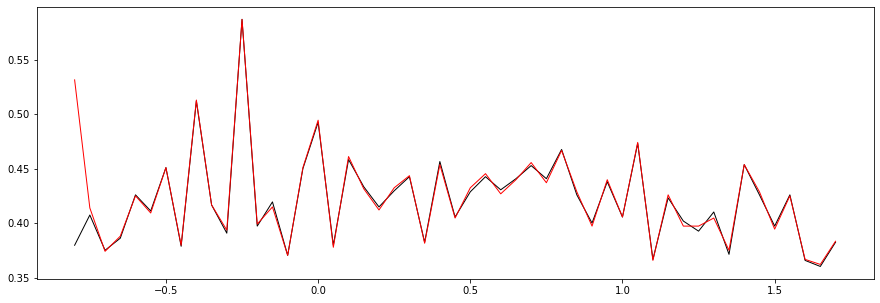

In [255]:
time_bin_x = time_bins[:-1]

f, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(time_bin_x, np.mean(trials_rate, axis=0), lw=1, c="black")
ax.plot(time_bin_x, np.mean(edge_trials_rate, axis=0), lw=1, c="red")

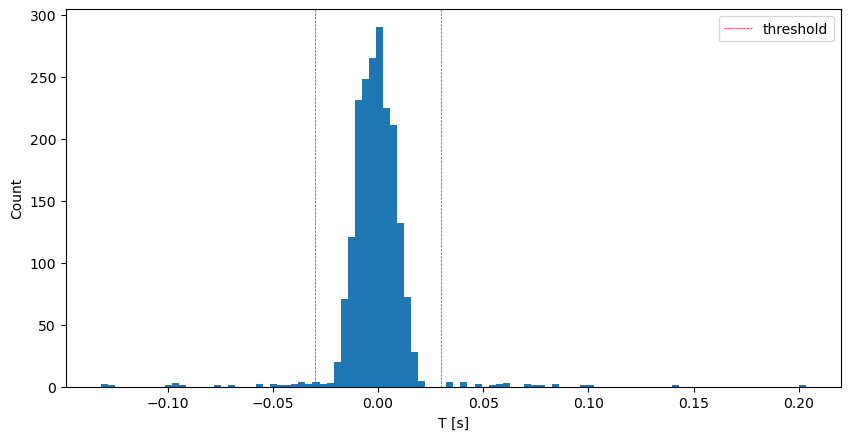

In [134]:
f, ax = plt.subplots(1, 1, figsize=(10,5), dpi=100)
ax.hist(adjustments, bins=100)
ax.set_xlabel("T [s]")
ax.set_ylabel("Count")
ax.axvline(0.03, lw=0.5, c="red", linestyle="--")
ax.axvline(-0.03, lw=0.5, c="red", linestyle="--", label="threshold")
ax.legend()

In [150]:
np.sum(metrics["burst_cut_off"]==False)

24555